<a href="https://colab.research.google.com/github/fleursomnium/Alzheimers-CNN/blob/main/CNN_MRI_Scans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! pip install tensorflow
! pip install kagglehub
! pip install psutil
! pip install matplotlib
%pip install scikit-learn

  Using cached tensorflow-2.18.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-manylinux2010_x86_64.whl.metadata (5.2 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached protobuf-5.28.3-cp38-abi3-manylinux2014_x86_64.whl.metadata (592 bytes)
  Using cached termcolor-2.5.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached wrapt-1.16.0-cp312-cp312-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.6 kB)
  Using cached grpcio-1.67.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metada

# CNN on MRIs scans for possible early detection of Alzheimer's

In [3]:
import os
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # to surpress the CUDA warnings

2024-11-13 04:12:25.628087: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-13 04:12:25.632638: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-13 04:12:25.644165: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731471145.666113     701 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731471145.671207     701 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-13 04:12:25.691078: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [4]:
import matplotlib.pyplot as plt
import numpy as np

In [5]:
# check how many cp we are working with
print(f"Number of CPU cores available: {os.cpu_count()}")

Number of CPU cores available: 16


## Importing the data to be used in this CNN

In [6]:
# importing the data
import kagglehub

# download latest version
path = kagglehub.dataset_download("uraninjo/augmented-alzheimer-mri-dataset")

print("Path to dataset files:", path)

/home/gitpod/.pyenv/versions/3.12.6/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 380M/380M [00:02<00:00, 192MB/s]  

Extracting files...


Path to dataset files: /home/gitpod/.cache/kagglehub/datasets/uraninjo/augmented-alzheimer-mri-dataset/versions/1


## Splitting Data to Training and Testing set

In [7]:
# set the base path to the downloaded dataset path
base_path = path  # this path comes from the API

train_dir = os.path.join(base_path, 'OriginalDataset')
test_dir = os.path.join(base_path, 'AugmentedAlzheimerDataset')

# printing the directories to verify
print("Train Directory:", train_dir)
print("Test Directory:", test_dir)

Train Directory: /home/gitpod/.cache/kagglehub/datasets/uraninjo/augmented-alzheimer-mri-dataset/versions/1/OriginalDataset
Test Directory: /home/gitpod/.cache/kagglehub/datasets/uraninjo/augmented-alzheimer-mri-dataset/versions/1/AugmentedAlzheimerDataset


In [8]:
# viewing the data provided
print("Train directory contents:", os.listdir(train_dir))
print("Test directory contents:", os.listdir(test_dir))

Train directory contents: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
Test directory contents: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


## Pre-Processing the data (distribution of the data)

In [9]:
# count the files inside each class directory
train_files = sum([len(files) for _, _, files in os.walk(train_dir)])
test_files = sum([len(files) for _, _, files in os.walk(test_dir)])

print(f"Train files count: {train_files}")
print(f"Test files count: {test_files}")

Train files count: 6400
Test files count: 33984


## Splitting the data into Training and Testing dataset

In [10]:
# loading datasets using categorical labels
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(128, 128),          # resize all images to 128x128 pixels
    batch_size=32,                  # load images in batches of 32 for efficient processin
    label_mode='categorical',       # assign categorical labels to each image (one-hot encoded)
    shuffle=True,                   # shuffle the dataset to promote model generalization
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(128, 128),
    batch_size=32,
    label_mode='categorical',
    shuffle=False,                  # do not shuffle to maintain consistent evaluation order
)

Found 6400 files belonging to 4 classes.


2024-11-13 04:13:00.640056: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Found 33984 files belonging to 4 classes.


In [11]:
# Extract class names and number of classes
class_names = train_dataset.class_names
num_classes = len(class_names)

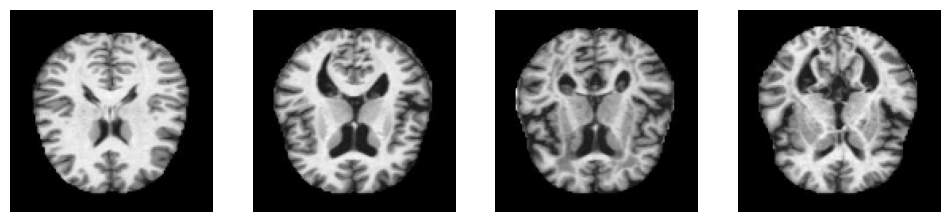

In [12]:
# Visualizing the first 4 images (without shuffling)

for images, labels in train_dataset.take(1):  # Take one batch
    plt.figure(figsize=(12, 4))  # Set the figure size for 4 images
    for i in range(4):  # Loop to display the first 4 images
        plt.subplot(1, 4, i+1)  # Create a 1x4 grid for images
        plt.imshow(images[i].numpy().astype("uint8"))  # Display the image
        plt.axis('off')  # Turn off axis
    plt.show()
    break  # Only process the first batch

### Setting aside parts of the original training dataset before being augmented AND **SHUFFLE = FALSE** (For comparison purposes to verify if augmentation is being done)

In [12]:
# Loading the dataset without shuffling (for comparison)
train_dataset_shuffle_false = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(128, 128),
    batch_size=32,
    label_mode='categorical',
    shuffle=False,  # No shuffling for predictable order
)

Found 6400 files belonging to 4 classes.


## Pipeline to parallilize the data across CPUs (potentially speed up the process)

In [13]:
# shard datasets for parallel processing across devices, reducing data loading overhead
num_shards = 4
shard_id = 0
train_dataset = train_dataset.shard(num_shards=num_shards, index=shard_id)
test_dataset = test_dataset.shard(num_shards=num_shards, index=shard_id)

# data Augmentation and Preprocessing for training data only
def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    return image, label

# normalization function for both training and testing data
def normalize_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# applying augmentation + normalization for train dataset only
train_dataset = train_dataset.map(lambda image, label: (tf.image.resize(image, [128, 128]), label))
train_dataset = train_dataset.map(augment_image)
train_dataset = train_dataset.map(normalize_image)

# applying normalization only for test dataset
test_dataset = test_dataset.map(lambda image, label: (tf.image.resize(image, [128, 128]), label))
test_dataset = test_dataset.map(normalize_image)

# # cache, shuffle, batch, and prefetch for optimization
# train_dataset = train_dataset.cache().shuffle(1000).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
# test_dataset = test_dataset.cache().batch(32).prefetch(tf.data.experimental.AUTOTUNE)

# remove .batch(32) in the preprocessing pipeline
train_dataset = train_dataset.cache().shuffle(1000).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(tf.data.experimental.AUTOTUNE)


# suppress tf messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # log level to 2 to ignore info messages and only show warnings and errors
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

=========================================       **Data Loading and Preprocessing**       ======================================== <br>
In this section, we prepare the training and testing datasets using TensorFlow's image_dataset_from_directory function, which loads images from their respective directories, resizes them to 128x128 pixels, and applies categorical labels. The training dataset is shuffled to promote model generalization, while the testing dataset is kept in a fixed order for consistent evaluation.

To optimize data loading for parallel processing, we shard each dataset into 4 parts. This sharding setup is designed for use with multiple devices, distributing data across devices and reducing loading overhead. Additionally, data augmentation techniques—such as random flips, brightness, and contrast adjustments—are applied only to the training dataset to enhance model generalization. Both datasets undergo normalization, scaling pixel values to the range [0, 1].

For further efficiency, we cache, shuffle, and prefetch the data. This caching minimizes redundant data loading, and prefetching enables the pipeline to asynchronously load batches during model training, reducing idle time. The combination of these preprocessing steps helps ensure that our data pipeline is optimized for both performance and generalization potential.

In [14]:
# print(f'train dataset shard size: {sum(1 for _ in train_dataset)}')
# print(f'test dataset shard size: {sum(1 for _ in test_dataset)}')

## Comparing original MRI scans with Augmented version<br> (test to verify if augmentation function is working properly)

Original batch shape: (32, 128, 128, 3)


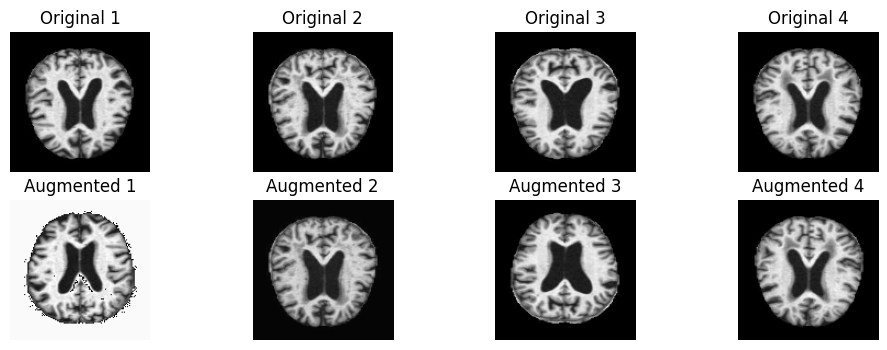

Augmented batch shape: (128, 128, 3)


In [16]:
# fetch the first batch from the original (non-augmented) dataset
for images, labels in train_dataset_shuffle_false.take(1):  # take only the first batch
    print(f"Original batch shape: {images.shape}")  # print the batch size (before augmentation)
    
    plt.figure(figsize=(12, 4))  # Set the figure size for 4 images

    # loop to display the first 4 images from the original (non-augmented) dataset
    for i in range(4):
        plt.subplot(2, 4, i+1)  # Top row for original images
        plt.imshow(images[i].numpy().astype("uint8"))  # Display the original image
        plt.axis('off')
        plt.title(f"Original {i+1}")

        # apply augmentation manually to the same images from the augmented dataset
        augmented_image, _ = augment_image(images[i], labels[i])

        # display the augmented image
        plt.subplot(2, 4, i+5)  # bottom row for augmented images
        plt.imshow(augmented_image.numpy().astype("uint8"))  # display the augmented image
        plt.axis('off')
        plt.title(f"Augmented {i+1}")

    plt.show()

    print(f"Augmented batch shape: {augmented_image.shape}")  # print the shape of the augmented image (after augmentation)

    break  # only process the first batch of images

## **Basic Sequential CNN**

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# define the CNN architecture using the add method
model = Sequential()

# first convolutional layer with L2 regularization
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(128, 128, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# second convolutional layer with L2 regularization
model.add(Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# third convolutional layer with L2 regularization
model.add(Conv2D(128, (3, 3), activation = 'relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# flatten and fully connected layers
model.add(Flatten())
model.add(Dense(128, activation = 'relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# output layer with softmax activation for multi-class classification
model.add(Dense(4, activation='softmax'))

# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# display model architecture
model.summary()

/home/gitpod/.pyenv/versions/3.12.6/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,306,564 (12.61 MB)

 Trainable params: 3,305,860 (12.61 MB)

 Non-trainable params: 704 (2.75 KB)

### This version logs images manually, so the set is pre-defined

In [18]:
import tensorflow as tf
import datetime

# define the log directory with a timestamp to keep logs organized
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# set up the TensorBoard callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,            # enable weight/bias histograms
    write_graph=True,            # log the computation graph
    write_images=True,           # log images (if relevant)
    update_freq='epoch',         # log metrics every epoch
    profile_batch=2              # profile the 2nd batch for performance analysis
)

# train the model and include the TensorBoard callback
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=10,
    callbacks=[tensorboard_callback]  # add the TensorBoard callback here
)

# optional: Log images manually if needed
# log images from the first batch of the train_dataset (just to check if we are using the images from the actual source)
for image_batch, label_batch in train_dataset.take(1):  # take 1 batch from the training dataset
    with tf.summary.create_file_writer(log_dir).as_default():
        tf.summary.image("Training data", image_batch, step=0)  # log images at step 0

Epoch 1/10


2024-11-13 00:26:49.516707: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:103] Profiler session initializing.
2024-11-13 00:26:49.516741: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:118] Profiler session started.
2024-11-13 00:26:49.517439: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:130] Profiler session tear down.


 1/50 ━━━━━━━━━━━━━━━━━━━━ 5:31 7s/step - accuracy: 0.1875 - loss: 2.8645

2024-11-13 00:26:56.297818: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:103] Profiler session initializing.
2024-11-13 00:26:56.297864: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:118] Profiler session started.


 2/50 ━━━━━━━━━━━━━━━━━━━━ 1:01 1s/step - accuracy: 0.1875 - loss: 2.9261

2024-11-13 00:26:57.497199: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:68] Profiler session collecting data.
2024-11-13 00:26:57.565337: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:130] Profiler session tear down.


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 605ms/step - accuracy: 0.3842 - loss: 2.1842

2024-11-13 00:28:07.862459: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 770703360 exceeds 10% of free system memory.


50/50 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.3852 - loss: 2.1806 - val_accuracy: 0.2820 - val_loss: 11.0432
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 909ms/step - accuracy: 0.5390 - loss: 1.5975

2024-11-13 00:29:31.466654: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 770703360 exceeds 10% of free system memory.


50/50 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.5394 - loss: 1.5964 - val_accuracy: 0.2820 - val_loss: 20.6222
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.6728 - loss: 1.2637

2024-11-13 00:30:40.738395: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 770703360 exceeds 10% of free system memory.


50/50 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.6727 - loss: 1.2639 - val_accuracy: 0.2820 - val_loss: 16.4318
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 851ms/step - accuracy: 0.7468 - loss: 1.0383

2024-11-13 00:31:58.213581: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 770703360 exceeds 10% of free system memory.


50/50 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.7468 - loss: 1.0385 - val_accuracy: 0.2632 - val_loss: 3.6455
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 840ms/step - accuracy: 0.8375 - loss: 0.8930

2024-11-13 00:33:28.999750: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 770703360 exceeds 10% of free system memory.


50/50 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.8373 - loss: 0.8934 - val_accuracy: 0.2848 - val_loss: 5.0563
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.9022 - loss: 0.7443 - val_accuracy: 0.2820 - val_loss: 6.8507
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.9487 - loss: 0.6407 - val_accuracy: 0.2828 - val_loss: 6.2753
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.9781 - loss: 0.5514 - val_accuracy: 0.2909 - val_loss: 4.9039
Epoch 9/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.9938 - loss: 0.4830 - val_accuracy: 0.2944 - val_loss: 5.2337
Epoch 10/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.9942 - loss: 0.4423 - val_accuracy: 0.3352 - val_loss: 3.6401


2024-11-13 00:39:31.717997: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Note: Images are from the first batch that you view in the tensorboard

 The goal of logging images like this is primarily to verify that the dataset is being loaded correctly and that the images are indeed coming from the expected source. <br>

 The images logged here are not necessarily the exact ones used for training because they are just the first batch from the dataset. <br>

 The train_dataset.take(1) takes one batch (the first one) of images from the training dataset. It logs the images for visual inspection. <br>

 This log is helpful for verifying that the dataset is being loaded as expected and that you're indeed working with the correct type of images (in your case, possibly MRI images for Alzheimer's classification). <br>

 None the less you are viewing the performance of the model in the tensorboard of this session

In [19]:
# # Include the TensorBoard callback with automatic logging
# tensorboard_callback = tf.keras.callbacks.TensorBoard(
#     log_dir=log_dir,
#     histogram_freq=1,            # Enable logging of weight/bias histograms
#     write_graph=True,            # Log the computation graph
#     write_images=True,           # Log images (during training)
#     update_freq='epoch',         # Log metrics every epoch (or 'batch' for more frequency)
#     profile_batch=2              # Profile the 2nd batch for performance analysis
# )

# # Train the model with the TensorBoard callback
# history = model.fit(
#     train_dataset,
#     validation_data=test_dataset,
#     epochs=10,
#     callbacks=[tensorboard_callback]  # Add the callback here for automatic logging
# )

### View TensorBoard for Performance Feedback

Now that the model has been trained, we can visualize its performance metrics using TensorBoard. This will provide graphs for the training and validation accuracy, loss, and more. 
<br>

### To view tensorboard
 run the following command in your terminal:<br>
`tensorboard --logdir=logs/fit --bind_all`
<br>

#### after running this you should see a link like: 
```
TensorBoard 2.18.0 at http://localhost:6007/ 
```

### Next press 
For
* Windows: CTR + Click <br>

* macos: CMD + Click<br>

#### and click on 
`http://localhost:6007/ `  

This will redirect you to the tensorboard of the model 

In [20]:
# # train the model (this is how we would run a training session without a tensorboard session)
# history = model.fit(
#     train_dataset,
#     epochs=10,  # Adjust epochs as needed
#     validation_data=test_dataset
# )

# **CNN Architecture with Batch Normalization for Enhanced Training Stability**

### (a) building the CNN architecture

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, ReLU
from tensorflow.keras.optimizers import Adam

# initialize the model
model_bnorm = models.Sequential()

# first convolutional layer + BatchNormalization
model_bnorm.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))  # No activation here, BatchNormalization will handle it
model_bnorm.add(BatchNormalization())
model_bnorm.add(MaxPooling2D((2, 2)))

# second convolutional layer + BatchNormalization
model_bnorm.add(Conv2D(64, (3, 3), activation='relu'))
model_bnorm.add(BatchNormalization())
model_bnorm.add(MaxPooling2D((2, 2)))

# third convolutional layer + BatchNormalization
model_bnorm.add(Conv2D(128, (3, 3), activation='relu'))
model_bnorm.add(BatchNormalization())
model_bnorm.add(MaxPooling2D((2, 2)))

# flatten and fully connected layers
model_bnorm.add(Flatten())
model_bnorm.add(Dense(128, activation='relu'))
model_bnorm.add(BatchNormalization())
model_bnorm.add(Dropout(0.5))  # Dropout for regularization

# output layer with 4 classes
model_bnorm.add(Dense(4, activation='softmax'))

# compile the model
model_bnorm.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',  # Categorical crossentropy for multi-class classification
    metrics=['accuracy']
)

# display model architecture
model_bnorm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,306,564 (12.61 MB)

 Trainable params: 3,305,860 (12.61 MB)

 Non-trainable params: 704 (2.75 KB)

### (b) Training the network

In [22]:
# train the model
history = model_bnorm.fit(
    train_dataset,  # Training data
    epochs=10,  # Adjust the number of epochs as needed
    validation_data=test_dataset,  # Optional: Validation data
    verbose=2  # Set verbose to 1 or 2 to get more information about the training process
)

# optional: You can also save the model after training
# model_bnorm.save('model_with_bn.h5')  # Save the model to a file

Epoch 1/10
50/50 - 59s - 1s/step - accuracy: 0.4044 - loss: 1.4728 - val_accuracy: 0.2642 - val_loss: 3.7788
Epoch 2/10
50/50 - 57s - 1s/step - accuracy: 0.5537 - loss: 1.0801 - val_accuracy: 0.2632 - val_loss: 19.6561
Epoch 3/10
50/50 - 55s - 1s/step - accuracy: 0.6544 - loss: 0.8474 - val_accuracy: 0.2673 - val_loss: 3.8226
Epoch 4/10
50/50 - 55s - 1s/step - accuracy: 0.7194 - loss: 0.6610 - val_accuracy: 0.2632 - val_loss: 6.0468
Epoch 5/10
50/50 - 62s - 1s/step - accuracy: 0.8475 - loss: 0.4429 - val_accuracy: 0.3210 - val_loss: 2.9022
Epoch 6/10
50/50 - 80s - 2s/step - accuracy: 0.8863 - loss: 0.3259 - val_accuracy: 0.3111 - val_loss: 3.6836
Epoch 7/10
50/50 - 61s - 1s/step - accuracy: 0.9394 - loss: 0.1866 - val_accuracy: 0.2877 - val_loss: 5.8965
Epoch 8/10
50/50 - 59s - 1s/step - accuracy: 0.9638 - loss: 0.1265 - val_accuracy: 0.3218 - val_loss: 3.8848
Epoch 9/10
50/50 - 58s - 1s/step - accuracy: 0.9831 - loss: 0.0811 - val_accuracy: 0.3062 - val_loss: 4.9144
Epoch 10/10
50/50 

# **Regularization**

## Applying L2 regularization to the kernels

In [23]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam

# initialize the model
model_with_bn = models.Sequential()

# first convolutional layer with L2 regularization + BatchNormalization
model_with_bn.add(layers.Conv2D(32, (3, 3), activation='relu',
                                kernel_regularizer=regularizers.l2(0.001),
                                input_shape=(128, 128, 3)))
model_with_bn.add(layers.BatchNormalization())
model_with_bn.add(layers.MaxPooling2D((2, 2)))

# second convolutional layer with L2 regularization + BatchNormalization
model_with_bn.add(layers.Conv2D(64, (3, 3), activation='relu',
                                kernel_regularizer=regularizers.l2(0.001)))
model_with_bn.add(layers.BatchNormalization())
model_with_bn.add(layers.MaxPooling2D((2, 2)))

# third convolutional layer with L2 regularization + BatchNormalization
model_with_bn.add(layers.Conv2D(128, (3, 3), activation='relu',
                                kernel_regularizer=regularizers.l2(0.001)))
model_with_bn.add(layers.BatchNormalization())
model_with_bn.add(layers.MaxPooling2D((2, 2)))

# flatten and fully connected layers with L2 regularization
model_with_bn.add(layers.Flatten())
model_with_bn.add(layers.Dense(128, activation='relu',
                                kernel_regularizer=regularizers.l2(0.001)))
model_with_bn.add(layers.BatchNormalization())
model_with_bn.add(layers.Dropout(0.5))  # Dropout for regularization

# output layer
model_with_bn.add(layers.Dense(4, activation='softmax'))

# compile the model
model_with_bn.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',  # Categorical crossentropy for multi-class classification
    metrics=['accuracy']
)

# display model architecture
model_with_bn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,306,564 (12.61 MB)

 Trainable params: 3,305,860 (12.61 MB)

 Non-trainable params: 704 (2.75 KB)

In [24]:
# compile the model
model_with_bn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# display the model architecture
model_with_bn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,306,564 (12.61 MB)

 Trainable params: 3,305,860 (12.61 MB)

 Non-trainable params: 704 (2.75 KB)

## training bn model

In [25]:
# train the model
history = model_with_bn.fit(
    train_dataset,                 # training dataset
    epochs=10,                     # number of epochs to train
    validation_data=test_dataset,  # validation dataset
)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.3867 - loss: 2.1387 - val_accuracy: 0.2820 - val_loss: 5.5997
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.5652 - loss: 1.5784 - val_accuracy: 0.2820 - val_loss: 16.0814
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.7155 - loss: 1.1567 - val_accuracy: 0.2820 - val_loss: 17.0037
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.7735 - loss: 1.0153 - val_accuracy: 0.3022 - val_loss: 4.4261
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.9044 - loss: 0.7476 - val_accuracy: 0.3230 - val_loss: 4.0114
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.8966 - loss: 0.7107 - val_accuracy: 0.3125 - val_loss: 3.7295
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.9473 - loss: 0.6105 - val_accuracy: 0.3352 - val_loss: 4.0310
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.9729 - loss: 0.5380 - val_accuracy: 0.3455 - val_los

## Incorporating Learning Rate Reduction to Improve Model Performance

In [26]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# reducing the Learning Rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              min_lr=1e-6)

history = model_with_bn.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset,
    callbacks=[reduce_lr]
)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.9963 - loss: 0.4074 - val_accuracy: 0.3361 - val_loss: 3.8717 - learning_rate: 0.0010
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.9990 - loss: 0.3698 - val_accuracy: 0.4023 - val_loss: 2.6476 - learning_rate: 0.0010
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.9998 - loss: 0.3476 - val_accuracy: 0.4077 - val_loss: 3.1403 - learning_rate: 0.0010
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.9986 - loss: 0.3217 - val_accuracy: 0.4683 - val_loss: 2.1276 - learning_rate: 0.0010
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 1.0000 - loss: 0.2924 - val_accuracy: 0.4454 - val_loss: 2.4263 - learning_rate: 0.0010
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.9998 - loss: 0.2682 - val_accuracy: 0.4374 - val_loss: 2.6240 - learning_rate: 0.0010
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 1.0000 - loss: 0.2477 - val_accuracy:

the scores for the above model are not that good as you can see the val_loss score increase instead of decreasing

# **Regularization and Optimization Techniques**

## Model 1: L2 Regularization + Dropout + BatchNormalization

In [27]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam

# Initialize the model
model_1 = models.Sequential()

# First convolutional layer with L2 regularization + BatchNormalization
model_1.add(layers.Conv2D(32, (3, 3), activation='relu',
                          kernel_regularizer=regularizers.l2(0.001),
                          input_shape=(128, 128, 3)))
model_1.add(layers.BatchNormalization())
model_1.add(layers.MaxPooling2D((2, 2)))

# Second convolutional layer with L2 regularization + BatchNormalization
model_1.add(layers.Conv2D(64, (3, 3), activation='relu',
                          kernel_regularizer=regularizers.l2(0.001)))
model_1.add(layers.BatchNormalization())
model_1.add(layers.MaxPooling2D((2, 2)))

# Third convolutional layer with L2 regularization + BatchNormalization
model_1.add(layers.Conv2D(128, (3, 3), activation='relu',
                          kernel_regularizer=regularizers.l2(0.001)))
model_1.add(layers.BatchNormalization())
model_1.add(layers.MaxPooling2D((2, 2)))

# Flatten and fully connected layers with L2 regularization
model_1.add(layers.Flatten())
model_1.add(layers.Dense(128, activation='relu',
                         kernel_regularizer=regularizers.l2(0.001)))
model_1.add(layers.BatchNormalization())


# Dropout layer for regularization
model_1.add(layers.Dropout(0.5))

# Output layer for classification
model_1.add(layers.Dense(4, activation='softmax'))

# Compile the model
model_1.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',  # Categorical crossentropy for multi-class classification
    metrics=['accuracy']
)

# Display model architecture
model_1.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,306,564 (12.61 MB)

 Trainable params: 3,305,860 (12.61 MB)

 Non-trainable params: 704 (2.75 KB)

In [28]:
history = model_1.fit(
    train_dataset,                  # Your training dataset
    epochs=10,                       # Number of epochs to train
    validation_data=test_dataset,     # Your validation dataset
    callbacks=[reduce_lr]            # Optional: Use the learning rate reduction callback
)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.3867 - loss: 2.1779 - val_accuracy: 0.2820 - val_loss: 6.6492 - learning_rate: 0.0010
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.5081 - loss: 1.6717 - val_accuracy: 0.2834 - val_loss: 10.8730 - learning_rate: 0.0010
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.6055 - loss: 1.4364 - val_accuracy: 0.2827 - val_loss: 21.7156 - learning_rate: 0.0010
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.6906 - loss: 1.1917 - val_accuracy: 0.2924 - val_loss: 17.5464 - learning_rate: 0.0010
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.8264 - loss: 0.8962 - val_accuracy: 0.3000 - val_loss: 9.9679 - learning_rate: 2.0000e-04
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.9209 - loss: 0.6849 - val_accuracy: 0.3110 - val_loss: 6.1408 - learning_rate: 2.0000e-04
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.9729 - loss: 0.5526 - val

## Model 2: L2 Regularization + Early Stopping

In [29]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping callback to monitor validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(128, 128, 3)),

    # Convolutional layers with L2 regularization
    tf.keras.layers.Conv2D(32, (3, 3), activation=None,
                           kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation=None,
                           kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), activation=None,
                           kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=None,
                          kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])

# Compile the model
model_2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fit the model with early stopping
history_2 = model_2.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset,
    callbacks=[early_stopping]
)

# Display model architecture
model_2.summary()

Epoch 1/10


50/50 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.3968 - loss: 2.0670 - val_accuracy: 0.2820 - val_loss: 2.9728
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.6409 - loss: 1.3405 - val_accuracy: 0.2854 - val_loss: 3.7007
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.7401 - loss: 1.0889 - val_accuracy: 0.2820 - val_loss: 5.2136
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.8457 - loss: 0.9018 - val_accuracy: 0.2898 - val_loss: 4.8218


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 126, 126, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 61, 61, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,918,286 (37.84 MB)

 Trainable params: 3,305,860 (12.61 MB)

 Non-trainable params: 704 (2.75 KB)

 Optimizer params: 6,611,722 (25.22 MB)

In [30]:
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define model with L2 regularization, Dropout, and BatchNormalization
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(128, 128, 3)),

    # First convolutional layer with L2 regularization
    tf.keras.layers.Conv2D(32, (3, 3), activation=None,
                           kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Second convolutional layer with L2 regularization
    tf.keras.layers.Conv2D(64, (3, 3), activation=None,
                           kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Third convolutional layer with L2 regularization
    tf.keras.layers.Conv2D(128, (3, 3), activation=None,
                           kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    # Dense layer with L2 regularization
    tf.keras.layers.Dense(128, activation=None,
                          kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),

    # Dropout layer
    tf.keras.layers.Dropout(0.5),

    # Output layer
    tf.keras.layers.Dense(4, activation='softmax')
])

# Compile the model
model_1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model_1.summary()

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Reduce the learning rate if validation loss doesn't improve
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model with callbacks
history = model_1.fit(
    train_dataset,                    # Your training dataset
    epochs=10,                         # Number of epochs to train
    validation_data=test_dataset,       # Your validation dataset
    callbacks=[early_stopping, reduce_lr]  # Add both callbacks for better optimization
)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 126, 126, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 61, 61, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,306,564 (12.61 MB)

 Trainable params: 3,305,860 (12.61 MB)

 Non-trainable params: 704 (2.75 KB)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.4290 - loss: 2.0792 - val_accuracy: 0.2832 - val_loss: 2.5879 - learning_rate: 0.0010
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.6008 - loss: 1.3984 - val_accuracy: 0.2821 - val_loss: 3.4293 - learning_rate: 0.0010
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.6699 - loss: 1.1934 - val_accuracy: 0.2835 - val_loss: 4.2881 - learning_rate: 0.0010
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.7656 - loss: 1.0476 - val_accuracy: 0.2910 - val_loss: 4.8762 - learning_rate: 0.0010


# **Transfer Learning**

In [33]:
import numpy as np
from tensorflow.keras.applications import VGG16
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# load the pre-trained VGG16 model (without the top layers for feature extraction)
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# function to extract features from the dataset using VGG16
def extract_features(dataset, model):
    features = []
    labels = []
    for image_batch, label_batch in dataset:
        feature_batch = model.predict(image_batch)  # Extract features for the batch
        features.append(feature_batch)
        labels.append(label_batch)

    # convert lists to numpy arrays
    features = np.vstack(features)
    labels = np.vstack(labels)

    # flatten the features for SVC (make them 2D)
    features = features.reshape(features.shape[0], -1)

    return features, np.argmax(labels, axis=1)  # Return the flattened features and the class labels

# extract features for training and testing datasets
train_features, train_labels = extract_features(train_dataset, vgg16_base)
test_features, test_labels = extract_features(test_dataset, vgg16_base)

# train SVC model
svc_model = SVC(kernel='linear', class_weight='balanced', decision_function_shape='ovr')  # OvR is default
svc_model.fit(train_features, train_labels)

# make predictions
svc_predictions = svc_model.predict(test_features)

# evaluate the SVC model
svc_accuracy = accuracy_score(test_labels, svc_predictions)
print("SVC Accuracy:", svc_accuracy)
print("SVC Classification Report:")
print(classification_report(test_labels, svc_predictions))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━

2024-11-13 01:40:45.295704: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

## ResNet50

In [34]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

# Load the pre-trained ResNet50 model without the top classification layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the layers of the pre-trained model
base_model.trainable = False

# Build the custom model
model_transfer = models.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')  # Output layer for 4 classes
])

# Compile the model
model_transfer.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model architecture
model_transfer.summary()

# Train the model on your dataset
history_transfer = model_transfer.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,500 (90.98 MB)

 Trainable params: 262,788 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 214s 4s/step - accuracy: 0.3619 - loss: 1.3798 - val_accuracy: 0.2820 - val_loss: 1.7004
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 225s 5s/step - accuracy: 0.4312 - loss: 1.1007 - val_accuracy: 0.2825 - val_loss: 1.7633
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 206s 4s/step - accuracy: 0.4165 - loss: 1.1143 - val_accuracy: 0.2830 - val_loss: 1.7764
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 204s 4s/step - accuracy: 0.4811 - loss: 1.0682 - val_accuracy: 0.2827 - val_loss: 1.7825
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 215s 4s/step - accuracy: 0.4424 - loss: 1.0871 - val_accuracy: 0.2931 - val_loss: 1.7535
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 204s 4s/step - accuracy: 0.4615 - loss: 1.0534 - val_accuracy: 0.2909 - val_loss: 1.8015
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 203s 4s/step - accuracy: 0.4613 - loss: 1.0655 - val_accuracy: 0.3094 - val_loss: 1.8458
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 212s 4s/step - accuracy: 0.4574 - loss: 1.0589 - val_accuracy: 0.2901 - v

### Fine-tuning
fine-tune the deeper layers of ResNet50 by unfreezing some layers and continuing training

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from sklearn.metrics import classification_report, f1_score
import numpy as np

# Create a separate dataset for ResNet50 with the required image size
resnet_train_dataset = train_dataset.map(lambda x, y: (tf.image.resize(x, [224, 224]), y))
resnet_test_dataset = test_dataset.map(lambda x, y: (tf.image.resize(x, [224, 224]), y))


# Build model using ResNet50 base
resnet50_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet50_base.trainable = False  # Freeze ResNet50 layers

resnet50_model = Sequential([
    resnet50_base,
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer='l2'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile and train ResNet50 model
resnet50_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
resnet50_history = resnet50_model.fit(resnet_train_dataset, validation_data=resnet_test_dataset, epochs=10)

# F1 score for ResNet50
resnet50_predictions = np.argmax(resnet50_model.predict(resnet_test_dataset), axis=1)
resnet50_f1 = f1_score(test_labels, resnet50_predictions, average='weighted')
print("ResNet50 F1 Score:", resnet50_f1)
print("ResNet50 Classification Report:")
print(classification_report(test_labels, resnet50_predictions))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 830s 17s/step - accuracy: 0.3754 - loss: 16.8669 - val_accuracy: 0.2820 - val_loss: 2.0320
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 996s 20s/step - accuracy: 0.4310 - loss: 1.5308 - val_accuracy: 0.3018 - val_loss: 1.9099
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 886s 18s/step - accuracy: 0.4416 - loss: 1.4040 - val_accuracy: 0.2820 - val_loss: 2.2188
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 889s 18s/step - accuracy: 0.4720 - loss: 1.3332 - val_accuracy: 0.2820 - val_loss: 1.9420
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 795s 16s/step - accuracy: 0.4964 - loss: 1.2745 - val_accuracy: 0.2820 - val_loss: 2.4102
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4838 - loss: 1.2658